In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import metrics
import visualizer
import utils

import importlib

In [ ]:
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

### Feed through the tracking pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

compute_segments = False
if compute_segments:
    final = tracker.segmentCells(frames, t)
else:
    final = t

print(final.head())

In [14]:
utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final, visualization="segments")

# Run Metrics

In [29]:
#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
#alternative = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted_old.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

#prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
#alternative = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted_old.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
alternative = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted_old.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)
alt_src = utils.loadDataFrame(alternative)

# Drop duplicates, interpolate, and filter sperm
pred_dd = utils.dropDuplicates(pred_src)
gt_dd = utils.dropDuplicates(gt_src)
alt_dd = utils.dropDuplicates(alt_src)

pred = utils.interpolateTracks(pred_dd)
gt = utils.interpolateTracks(gt_dd)
alt = utils.interpolateTracks(alt_dd)

pred = metrics.filterSperm(pred)
gt = metrics.filterSperm(gt)
alt = metrics.filterSperm(alt)


# print(len(pred_src), len(gt_src), len(alt_src))
# print("Unique sperm in prediction source:", len(pred_src['sperm'].unique()))
# print("Unique sperm in ground truth source:", len(gt_src['sperm'].unique()))
# print("Unique sperm in alternative source:", len(alt_src['sperm'].unique()))

# print(len(pred), len(gt), len(alt))
# # Count number of unique sperm in each DataFrame
# print("Unique sperm in prediction:", len(pred['sperm'].unique()))
# print("Unique sperm in ground truth:", len(gt['sperm'].unique()))
# print("Unique sperm in alternative:", len(alt['sperm'].unique()))



In [30]:
# Compute stats for each file
ps = 0.26  # pixel size in micrometers
gt = stats.computeAllStats(gt,pixel_size=ps,interpolate=False)
pred = stats.computeAllStats(pred,pixel_size=ps,interpolate=False)
alt = stats.computeAllStats(alt,pixel_size=ps,interpolate=False)



In [31]:
#print(pred.head())
import pandas as pd

# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Prediction': [pred['VAP'].max(), pred['VSL'].max(), pred['VCL'].max(), pred['ALH_mean'].max(), pred['ALH_max'].max(), pred['BCF'].max()],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
    'Alternative': [alt['VAP'].max(), alt['VSL'].max(), alt['VCL'].max(), alt['ALH_mean'].max(), alt['ALH_max'].max(), alt['BCF'].max()]
})

print(summary_df)


       Stat  Prediction  Ground Truth  Alternative
0       VAP   18.430677     18.432733    12.888723
1       VSL   18.263006     18.267758    13.505768
2       VCL   18.742511     18.912966    13.059805
3  ALH_mean  145.796785    145.934880    94.084246
4   ALH_max  186.338851    186.198261   168.378182
5       BCF    0.480916      0.671053     0.870968


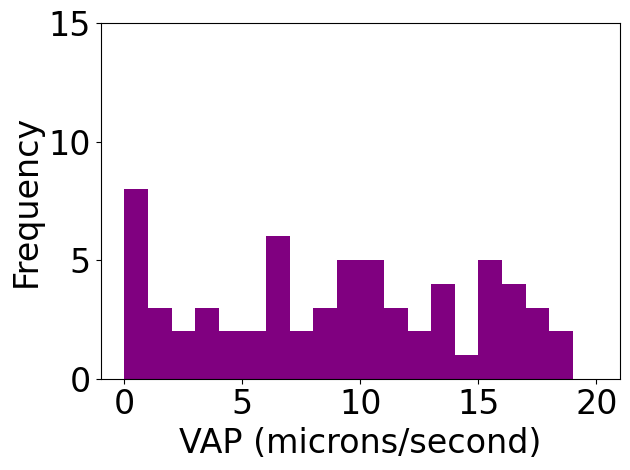

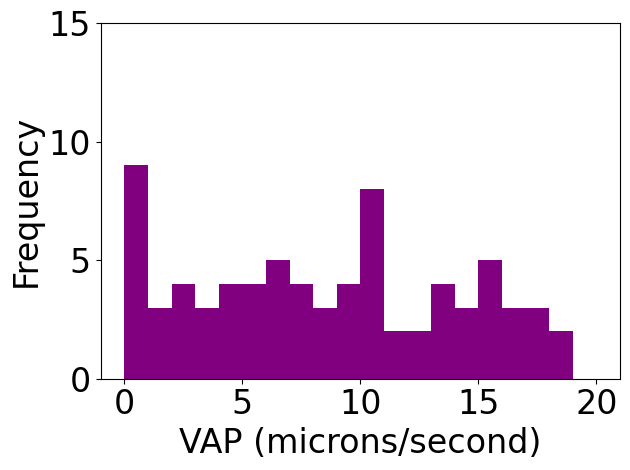

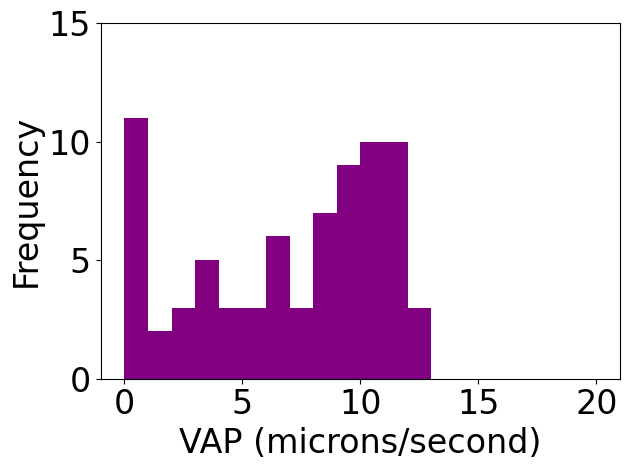

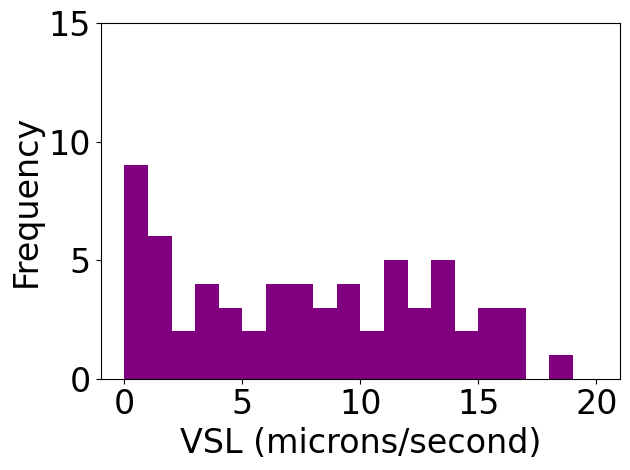

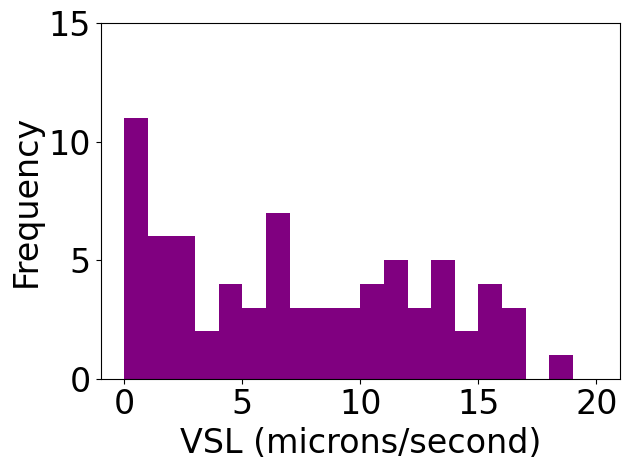

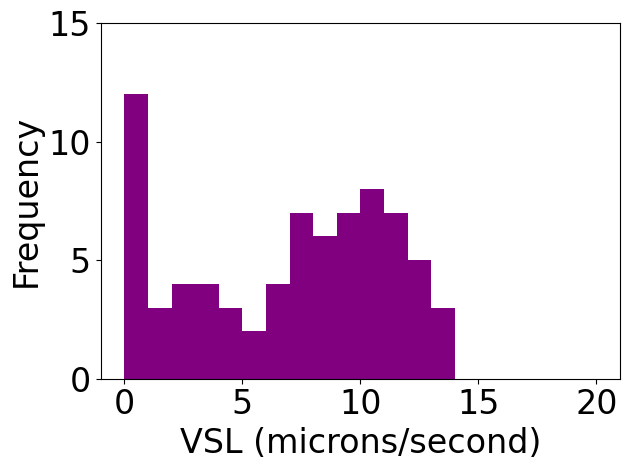

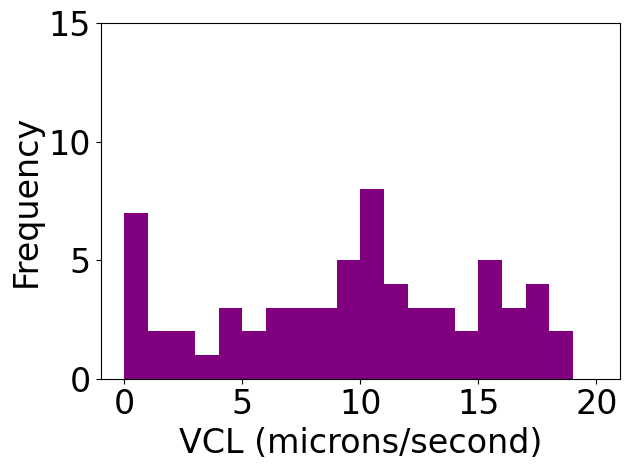

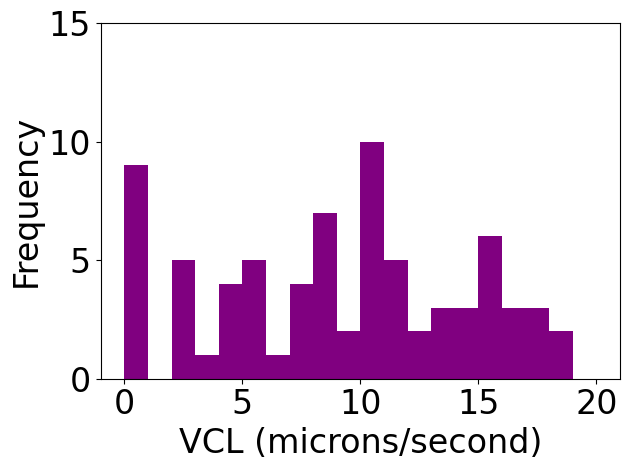

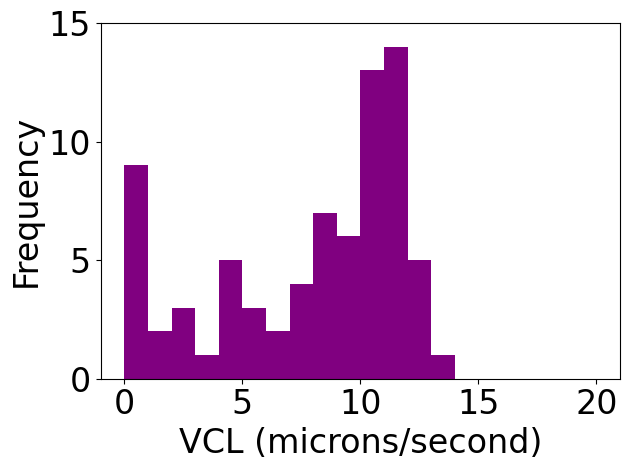

In [32]:
import matplotlib.pyplot as plt

# Generate historgrams for VSL, VCL, and VAP
def plotStat(data,stat="VAP",method="gt",fs = 24):

    # Get unique sperm
    sperm_ids = data['sperm'].unique()

    # Get first stat values for each sperm id
    first_values = data.groupby('sperm').first()[stat]

    plt.hist(first_values, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], alpha=1.0, color='purple')
    plt.xlabel(stat + " (microns/second)",fontsize=fs)
    xticks = [0,5,10,15,20]
    plt.xticks(xticks, xticks, fontsize=fs)
    plt.ylabel('Frequency', fontsize=fs)
    yticks = [0,5,10,15]
    plt.yticks(yticks, yticks, fontsize=fs)
    #plt.title(f'{stat} Distribution')
    #plt.legend()
    plt.tight_layout()
    plt.savefig(f'{stat}_distribution_{method}.pdf')
    plt.show()

plotStat(gt,stat="VAP")
plotStat(pred,stat="VAP")
plotStat(alt,stat="VAP")

plotStat(gt,stat="VSL")
plotStat(pred,stat="VSL")
plotStat(alt,stat="VSL")

plotStat(gt,stat="VCL")
plotStat(pred,stat="VCL")
plotStat(alt,stat="VCL")

